# trackingML DL with GlueX Fall 2018 data part 4

Here I start using the new labels file "trackingML_features2.csv" which includes the full inverse covariance matrix. This first section just reads the first 1000 tracks and prints the labels in a format that visually indicates the relations between the labels.

In [10]:
import os
import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features2.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels2.csv'
MAX_TRACKS  = 10000  # Number of tracks(lines) to read from training file

# Get fraction of features file read so we can estimate fraction of data we're using
percent_read = 0.0;
with open(TRAIN_FILE) as f:
    f.readline()  # skip header
    for i in range(100): percent_read = percent_read + float(len(f.readline()) + 1)
    percent_read = 100.0*percent_read/os.path.getsize(TRAIN_FILE)*MAX_TRACKS/100.0

# NOTE: Only reading first few rows for now since it takes a long time to read entire file
df       = pd.read_csv(TRAIN_FILE  , nrows=MAX_TRACKS)
labelsdf = pd.read_csv(LABELS_FILE , nrows=MAX_TRACKS)

NINPUTS = len(df.columns)

print('\n\nNumber of input features per track: %d' % NINPUTS)
print('Number of tracks read: %d  ( %3.2f%% of total )' % (len(df.index), percent_read))
print('Label Names: ')
print('           ' + ', '.join(labelsdf.columns[0:1])) # event
print('           ' + ', '.join(labelsdf.columns[1:6])) # q_over_pt, phi, tanl, D, z
print('              ' + '           '*0 + ',    '.join(labelsdf.columns[6:11])) # cov_01 - cov_04
print('              ' + '           '*1 + ',    '.join(labelsdf.columns[11:15])) # cov_11 - cov_14
print('              ' + '           '*2 + ',    '.join(labelsdf.columns[15:18])) # cov_22 - cov_24
print('              ' + '           '*3 + ',    '.join(labelsdf.columns[18:20])) # cov_33 - cov_34
print('              ' + '           '*4 + ',    '.join(labelsdf.columns[20:21])) # cov_44
print('           ' + ', '.join(labelsdf.columns[21:26])) # invcov_00 - invcov_04
print('           ' + ', '.join(labelsdf.columns[26:31])) # invcov_10 - invcov_14
print('           ' + ', '.join(labelsdf.columns[31:36])) # invcov_20 - invcov_24
print('           ' + ', '.join(labelsdf.columns[36:41])) # invcov_30 - invcov_34
print('           ' + ', '.join(labelsdf.columns[41:46])) # invcov_40 - invcov_44
print('           ' + ', '.join(labelsdf.columns[46:]))   # chisq, Ndof
print('\n')



Number of input features per track: 5835
Number of tracks read: 10000  ( 95.29% of total )
Label Names: 
           event
           q_over_pt, phi, tanl, D, z
              cov_00,    cov_01,    cov_02,    cov_03,    cov_04
                         cov_11,    cov_12,    cov_13,    cov_14
                                    cov_22,    cov_23,    cov_24
                                               cov_33,    cov_34
                                                          cov_44
           invcov_00, invcov_01, invcov_02, invcov_03, invcov_04
           invcov_10, invcov_11, invcov_12, invcov_13, invcov_14
           invcov_20, invcov_21, invcov_22, invcov_23, invcov_24
           invcov_30, invcov_31, invcov_32, invcov_33, invcov_34
           invcov_40, invcov_41, invcov_42, invcov_43, invcov_44
           chisq, Ndof




# Check the inverse matrix

Here I want to check that the covariance matrix inverted properly. In order to check it for multiple events, I define a procedure for doing this with the row number as the single argument. I just do this using numpy.

In [11]:


def TestInverse( irow, print_prod=False ):
    
    row = labelsdf.iloc[[irow]]

    # Copy symmetric covariance into 5x5 tensor. 
    cov = np.zeros(shape=(5,5))
    cov [0,:] = [row['cov_00'], row['cov_01'], row['cov_02'], row['cov_03'], row['cov_04']]
    cov [1,:] = [row['cov_01'], row['cov_11'], row['cov_12'], row['cov_13'], row['cov_14']]
    cov [2,:] = [row['cov_02'], row['cov_12'], row['cov_22'], row['cov_23'], row['cov_24']]
    cov [3,:] = [row['cov_03'], row['cov_13'], row['cov_23'], row['cov_33'], row['cov_34']]
    cov [4,:] = [row['cov_04'], row['cov_14'], row['cov_24'], row['cov_34'], row['cov_44']]
    
    # Copy relevant values and simultaneously reshape inverse covariance
    # (much more succint when all values are present!)
    inv = np.reshape( row.values[0,21:46], (5,5) ) 
    
    # Multiply two matrices. Note that we don't need to transpose
    # either of these since both are symmetric
    mydot = np.dot(inv, cov)
    
    # Optionally print product which should be identity matrix (or close to it)
    if print_prod:
        print(np.array2string(mydot, max_line_width=160))
    
    # Test if this is close to an identity matrix by taking difference with
    # identity matrix and calculating RMS of all elements
    diff = mydot - np.identity(5)
    rms = np.sqrt( np.sum( np.square(diff)))
    if print_prod: print('rms: %f' % rms)
    return rms < 1.0E-2

N = MAX_TRACKS
Nbad = 0
last_bad = -1
for irow in range(0, N):
    isValid = TestInverse( irow )
    if not isValid:
        #print('Bad inverse matrix for row: %d' % irow)
        Nbad += 1
        last_bad = irow

print('Found %d bad rows out of %d (%3.2f%%)' % (Nbad, N, 100.0*Nbad/N))
print('Details of the last bad row (%d):' % last_bad)
TestInverse( last_bad, True )


Found 1738 bad rows out of 10000 (17.38%)
Details of the last bad row (9999):
[[ 1.00011873e+00  1.23830000e-07  1.11508200e-05  7.42373040e-04  1.34615678e-02]
 [-1.76319262e+00  9.05618010e-01 -1.60376522e-01 -1.36453025e-01 -2.22235505e+00]
 [ 1.12156722e-01  7.83319790e-03  1.02021392e+00  1.18767735e-02  1.71632196e-01]
 [ 7.58442000e-02 -4.91616320e-03  1.62579400e-03  9.94351104e-01 -5.49573600e-02]
 [-8.78888800e-03 -1.39880680e-04 -9.06736000e-04 -1.68922400e-04  9.95753492e-01]]
rms: 2.855296


False

## Bad Inverses
The above shows nearly 20% of the rows have inverse matrices that are not very good. The cut on the rms<1.0E-2 is pretty arbitrary, but even if it were set to 1, there is still more than 7% of the rows failing that test.

So what do I do? Well, there are a couple of options:

1. The matrix inversion was done using the TMatrixTSym<float>::InvertFast() method. I could switch to another method which may be more robust.
    
2. Drop the tracks that fail the criteria for inversion. (See more on this after next cell.)
    
The quickest/easiest thing is to just switch to using "Invert" instead of "InvertFast" so I try that first. In order to maintain the inputs for the above cells, I create a new set of files that include "3" in the name.

In [12]:

TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features3.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels3.csv'

df       = pd.read_csv(TRAIN_FILE  , nrows=MAX_TRACKS)
labelsdf = pd.read_csv(LABELS_FILE , nrows=MAX_TRACKS)

N = MAX_TRACKS
Nbad = 0
last_bad = -1
for irow in range(0, N):
    isValid = TestInverse( irow )
    if not isValid:
        #print('Bad inverse matrix for row: %d' % irow)
        Nbad += 1
        last_bad = irow

print('Found %d bad rows out of %d (%3.2f%%)' % (Nbad, N, 100.0*Nbad/N))
print('Details of the last bad row (%d):' % last_bad)
TestInverse( last_bad, True )


Found 1365 bad rows out of 10000 (13.65%)
Details of the last bad row (9967):
[[4.13138194e-05 4.00014036e-06 4.45758685e-06 7.97475367e-06 5.66036006e-05]
 [4.00014036e-06 3.96345950e-07 6.50858603e-07 1.08784969e-06 7.62799244e-06]
 [4.45758685e-06 6.50858603e-07 5.83607937e-06 8.55396263e-06 5.84295963e-05]
 [7.97475367e-06 1.08784969e-06 8.55396263e-06 1.26215945e-05 8.63091038e-05]
 [5.66036006e-05 7.62799244e-06 5.84295963e-05 8.63091038e-05 5.90325169e-04]]
rms: 2.235777


False

## Bad Inverses .... still

So it dropped the "bad" inverses from 17.4% to 13.7%. Better, but still not good enough. Note that if I change the criteria for bad to be 1 then there are still 3.8% of bad rows. The use of "Invert" instead of "InvertFast" didn't change the processing time significantly for producing the files. This is because it is doing full tracking so the inversion of a single 5x5 matrix is pretty tiny compared to that.

This means we should look at option 2.: *Drop bad tracks*. If we left these in, then most likely, the loss calculated for these tracks will be quite large and the model will be strongly influenced by them. This may argue for an even more stringent cut on the how good the matrix inversion is. I'm concerned though that there may be a correlation of the poorer inversions with some particular area of the 5-parameter phase space. It may be that dropping these tracks will leave us with a model that is incapable of producing good results for this area. Sigh... I guess we need to at least peek at where these bad tracks may be in the state vector space.

In order to do this, we need to add a column to the original labelsdf dataframe that has the rms value. This will take a bit to compute so be patient with the next cell.

In [13]:

# Define new procedure to calculate rms only. This is just a compacted
# version of TestInverse above.
def GetRMS( irow ):
    
    row = labelsdf.iloc[[irow]]

    cov = np.zeros(shape=(5,5))
    cov [0,:] = [row['cov_00'], row['cov_01'], row['cov_02'], row['cov_03'], row['cov_04']]
    cov [1,:] = [row['cov_01'], row['cov_11'], row['cov_12'], row['cov_13'], row['cov_14']]
    cov [2,:] = [row['cov_02'], row['cov_12'], row['cov_22'], row['cov_23'], row['cov_24']]
    cov [3,:] = [row['cov_03'], row['cov_13'], row['cov_23'], row['cov_33'], row['cov_34']]
    cov [4,:] = [row['cov_04'], row['cov_14'], row['cov_24'], row['cov_34'], row['cov_44']]
    inv = np.reshape( row.values[0,21:46], (5,5) ) 
    mydot = np.dot(inv, cov)
    diff = mydot - np.identity(5)
    rms = np.sqrt( np.sum( np.square(diff)))
    return rms

# Add the 'rms' column, intialized with zeros
Nrows = labelsdf.shape[0]

# Calculate RMS for all rows
rms_all = np.zeros((Nrows))
for irow in range(0,Nrows):
    rms_all[irow] = GetRMS( irow )

labelsdf['rms'] = rms_all


Display the modified dataframe and make a plot of rms so we can better see any structure that might help us place a cut.

,event,q_over_pt,phi,tanl,D,z,cov_00,cov_01,cov_02,cov_03,...,invcov_33,invcov_34,invcov_40,invcov_41,invcov_42,invcov_43,invcov_44,chisq,Ndof,rms
0,35,-1.85473,0.060420,3.526730,-0.121368,72.6735,0.005740,0.000406,-0.000345,-0.002727,...,2325.21000,20.023300,-1.990670,55.57040,-283.30400,20.023300,23.460000,38.69020,5,0.000179
1,33,-5.36424,-0.801458,0.699402,-0.540602,67.5354,0.010936,0.000659,-0.000910,-0.005587,...,198.58100,-32.558100,-18.958500,-255.23800,-320.84200,-32.558100,41.632900,61.25520,12,0.000033
2,33,-9.91769,-1.734460,6.381690,0.583704,62.3069,0.884910,0.100848,-0.175049,-1.258430,...,5.79647,0.057882,-0.132012,-4.06933,-1.61773,0.057882,0.133685,0.12292,21,0.000835
3,33,-9.41295,-1.688510,6.366590,0.069051,61.1478,0.599437,0.022573,-0.140856,-0.182858,...,48.30680,-2.488610,0.185975,-21.30760,-2.73038,-2.488610,0.431681,15.36030,9,0.000824
4,34,-6.75901,-1.296550,0.800141,-0.032352,45.6102,0.026933,0.000508,-0.003337,0.014412,...,240.35700,136.577000,-9.886810,-725.13100,-193.24900,136.577000,104.896000,40.00240,7,0.000117


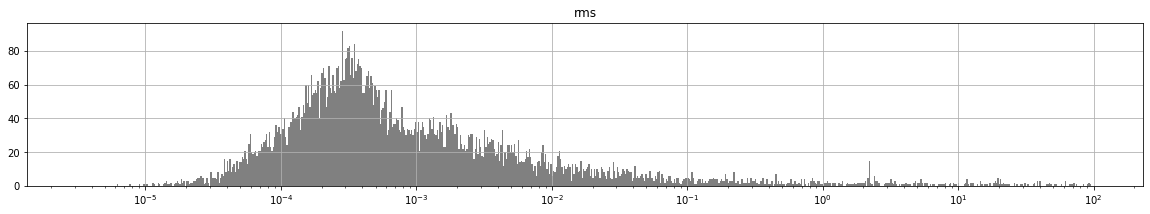

In [14]:
import matplotlib.pyplot as plt

# Plot RMS values
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.set_xscale("log")
#ax.set_yscale("log")
bins = 10.0**(np.arange(-550,200)/100.0)
labelsdf.hist(ax=ax, column=['rms'], bins=bins, color='grey')

labelsdf.head()

OK, so it looks like there is a little bump just past $10^{-3}$. If I place the cut there, it cuts out quite a bit of the tracks. It also turns out that between $10^{-3}$ and $10^{-2}$ there are quite a few tracks from the more fiducial parts of the phase space. I somewhat arbitrarily choose to cut rms values greater than $10^{-2}$.

Now, filter out the rows with "good" rms values so we can plot the state vector paremeters for the "bad" ones.

Unfortunately, the following is a little messy due to plotting a ratio of histograms. Maybe there is a better way, but it took a while just to come up with this. The most important thing to look at here is the last row of 3 plots.

/home/davidl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/davidl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'z - bad rms')

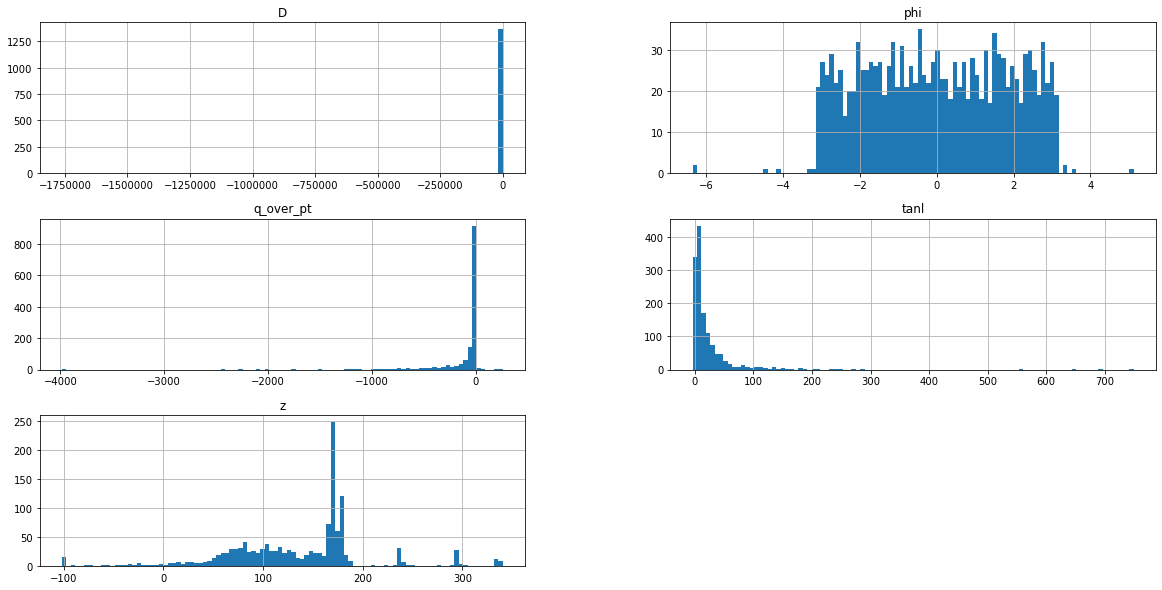

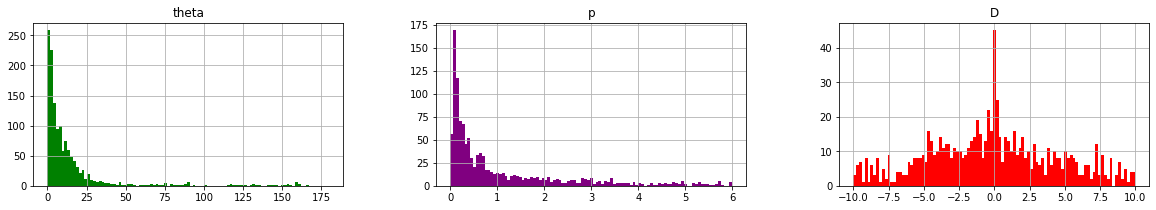

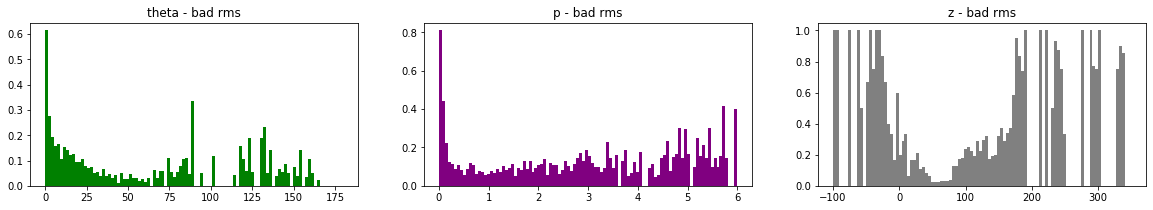

In [15]:
import matplotlib.pyplot as plt

labelsdf_bad = labelsdf[labelsdf['rms']>1.0E-2]

# Plot all values from state vector
h = labelsdf_bad.hist(column=['q_over_pt','phi','D', 'tanl', 'z'], bins=100, figsize=(20.0,10.0))

# Convert the dip angle and q_over_pt into theta and p and plot those as well
theta = np.rad2deg(np.pi/2.0-np.arctan(labelsdf_bad['tanl']))
dftheta = pd.DataFrame(data=theta).rename(columns={'tanl':'theta'})

pmag = -1.0/labelsdf_bad['q_over_pt']/np.sin(np.deg2rad(theta))
dfpmag = pd.DataFrame(data=pmag).rename(columns={0:'p'})

fig, ax = plt.subplots(1,3, figsize=(20,3))
dftheta.hist(ax=ax[0], column=['theta'], bins=np.linspace(0.0, 180.0, 100), color='green')
dfpmag.hist(ax=ax[1], bins=np.linspace(0.0, 6.0, 100), color='purple')
labelsdf_bad.hist(ax=ax[2], column=['D'],bins=np.linspace(-10.0, 10.0, 100), color='red')

# Normalize theta to all events
theta_norm = np.rad2deg(np.pi/2.0-np.arctan(labelsdf['tanl']))
htheta_norm = np.histogram( theta_norm, bins=100, range=(0.0,180.0) )
htheta      = np.histogram( theta     , bins=100, range=(0.0,180.0) )
ratio_theta = np.nan_to_num( htheta[0] / htheta_norm[0] )
hist_theta,bins_theta = np.histogram(htheta[1][:-1], bins=htheta[1], weights=ratio_theta)

# Normalize z to all events
hz_norm = np.histogram( labelsdf['z'], bins=100, range=(-100.0,350.0) )
hz      = np.histogram( labelsdf_bad['z']     , bins=100, range=(-100.0,350.0) )
ratio_z = np.nan_to_num( hz[0] / hz_norm[0])
hist_z,bins_z = np.histogram(hz[1][:-1], bins=hz[1], weights=ratio_z)

# Normalize p to all events
pmag_norm = -1.0/labelsdf['q_over_pt']/np.sin(np.deg2rad(theta_norm))
hp_norm = np.histogram( pmag_norm, bins=100, range=(0.0, 6.0) )
hp      = np.histogram( pmag     , bins=100, range=(0.0, 6.0) )
ratio_p = np.nan_to_num( hp[0] / hp_norm[0])
hist_p,bins_p = np.histogram(hp[1][:-1], bins=hp[1], weights=ratio_p)

# plot theta for bad rms
fig, ax = plt.subplots(1,3, figsize=(20,3))
width = 1.0 * (bins_theta[1] - bins_theta[0])
center = (bins_theta[:-1] + bins_theta[1:]) / 2
ax[0].bar(center, hist_theta, align='center', width=width, color='green')
ax[0].set_title('theta - bad rms')

# plot p for bad rms
width = 1.0 * (bins_p[1] - bins_p[0])
center = (bins_p[:-1] + bins_p[1:]) / 2
ax[1].bar(center, hist_p, align='center', width=width, color='purple')
ax[1].set_title('p - bad rms')

# plot z for bad rms
width = 1.0 * (bins_z[1] - bins_z[0])
center = (bins_z[:-1] + bins_z[1:]) / 2
ax[2].bar(center, hist_z, align='center', width=width, color='grey')
ax[2].set_title('z - bad rms')

## Where the bad covariences roam!

The bottom 3 plots above are of the "efficiency" of bad rms values. Larger values indicate where the bad rms values represent a larger fraction of the total tracks. These indicate that low-momentum, forward going tracks not coming from the GlueX target (50-80 on the z-plot) are where we get bad covariances. Note that you can't tell from these wheher one of these correlates to the bad RMS at a time, or all. The one good thing may be that the momentum plot shows a somewhat flat distribution everywhere except really low-momentun tracks.

So what does this tell me?... Well, what this tells me is that we can go ahead and train a model on the "good" rms events, but we'll really need to study how the model results compare to the existing Kalman filter results. Of course, we already knew that!

To make things a little simpler as I move forward, I generated a new pair of features and labels files that omit tracks with RMS>1.0E-2. I do a quick check here just to make sure the plots look the same if I don't do any cuts on RMS here. 

Found 1032 bad rows out of 10000 (10.32%)
Details of the last bad row (9989):
[[ 1.00025850e+00  2.68382560e-05 -2.20271580e-04  1.01668900e-04 -5.57316800e-04]
 [-8.62582500e-03  9.99211538e-01  4.07031700e-03 -9.28858000e-03  1.11881420e-01]
 [-2.94872750e-03  1.58534560e-04  9.99243382e-01  7.88070100e-04  9.21579000e-03]
 [ 1.10195046e-02  3.49316520e-05 -1.59000994e-03  9.97209765e-01 -2.57242000e-03]
 [-1.44513900e-05  3.75524278e-05  3.89170000e-05 -3.67270600e-05  1.00029920e+00]]
rms: 0.113706


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f529bbc1d68>],
      dtype=object)

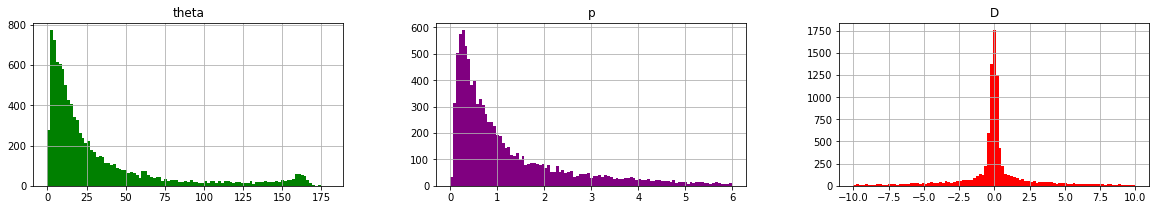

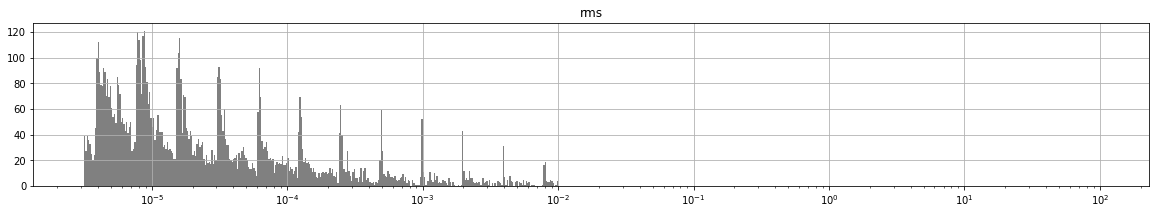

In [16]:
TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features4.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels4.csv'

df       = pd.read_csv(TRAIN_FILE  , nrows=MAX_TRACKS)
labelsdf = pd.read_csv(LABELS_FILE , nrows=MAX_TRACKS)

N = MAX_TRACKS
Nbad = 0
last_bad = -1
for irow in range(0, N):
    isValid = TestInverse( irow )
    if not isValid:
        #print('Bad inverse matrix for row: %d' % irow)
        Nbad += 1
        last_bad = irow

print('Found %d bad rows out of %d (%3.2f%%)' % (Nbad, N, 100.0*Nbad/N))
print('Details of the last bad row (%d):' % last_bad)
TestInverse( last_bad, True )

# Convert the dip angle and q_over_pt into theta and p and plot those as well
theta = np.rad2deg(np.pi/2.0-np.arctan(labelsdf['tanl']))
dftheta = pd.DataFrame(data=theta).rename(columns={'tanl':'theta'})

pmag = -1.0/labelsdf['q_over_pt']/np.sin(np.deg2rad(theta))
dfpmag = pd.DataFrame(data=pmag).rename(columns={0:'p'})

fig, ax = plt.subplots(1,3, figsize=(20,3))
dftheta.hist(ax=ax[0], column=['theta'], bins=np.linspace(0.0, 180.0, 100), color='green')
dfpmag.hist(ax=ax[1], bins=np.linspace(0.0, 6.0, 100), color='purple')
labelsdf.hist(ax=ax[2], column=['D'],bins=np.linspace(-10.0, 10.0, 100), color='red')

fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.set_xscale("log")
#ax.set_yscale("log")
bins = 10.0**(np.arange(-550,200)/100.0)
labelsdf.hist(ax=ax, column=['rms'], bins=bins, color='grey')

Well crap. The RMS distribution (bottom plot of previous cell) looks very different from what we saw up above. It looks like there is some discrepancy between how it is being calculated in the plugin using the ROOT linear algebra package and how it is being done here using numpy. Both cover somewhat similar ranges though the ROOT plot here does tend to lower values and does not look nearly as smooth. I'll need to look at one or two tracks in detail to figure this out.

I modified the plugin to print out the covariance, inverse, and product matrices. I up'd the output file names (e.g. "trackingML_labels5.csv") and ran it for a few events. The relevant output for the first track has been pasted below. In the next cell, I print the same things as calculated by numpy here.

<pre>
-------------------------------------------------------------     
event: 1   sum=2.44217e-12  rms=1.56274e-06
 covariance:

5x5 matrix is as follows

     |      0    |      1    |      2    |      3    |      4    |
----------------------------------------------------------------------
   0 |   0.001944   0.0001158  -0.0001158   0.0006004    0.001237 
   1 |  0.0001158   9.222e-05   1.214e-06   0.0006034  -3.812e-05 
   2 | -0.0001158   1.214e-06   0.0001297   1.698e-05   -0.001466 
   3 |  0.0006004   0.0006034   1.698e-05    0.004469  -0.0003482 
   4 |   0.001237  -3.812e-05   -0.001466  -0.0003482     0.02284 

 inverse:

5x5 matrix is as follows

     |      0    |      1    |      2    |      3    |      4    |
----------------------------------------------------------------------
   0 |      606.4       -1903       579.7       173.6       3.831 
   1 |      -1903   9.903e+04      -490.6  -1.311e+04       36.99 
   2 |      579.7      -490.6   2.863e+04       20.23        1805 
   3 |      173.6  -1.311e+04       20.23        1970     0.05584 
   4 |      3.831       36.99        1805     0.05584       159.5 

 product:

5x5 matrix is as follows

     |      0    |      1    |      2    |      3    |      4    |
----------------------------------------------------------------------
   0 |          1   4.336e-09  -8.382e-09   7.998e-08    1.49e-08 
   1 |  1.341e-07           1  -1.118e-08   7.795e-07   4.768e-07 
   2 |          0           0           1   -5.96e-08           0 
   3 | -8.281e-08    1.36e-07   1.615e-09           1  -2.934e-08 
   4 |          0           0           0   3.725e-09           1 

-------------------------------------------------------------
</pre>

In [24]:
TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features5.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels5.csv'

df       = pd.read_csv(TRAIN_FILE  , nrows=10)
labelsdf = pd.read_csv(LABELS_FILE , nrows=10)


# Copy symmetric covariance into 5x5 tensor.
irow = 0
row = labelsdf.iloc[[irow]]
cov = np.zeros(shape=(5,5))
cov [0,:] = [row['cov_00'], row['cov_01'], row['cov_02'], row['cov_03'], row['cov_04']]
cov [1,:] = [row['cov_01'], row['cov_11'], row['cov_12'], row['cov_13'], row['cov_14']]
cov [2,:] = [row['cov_02'], row['cov_12'], row['cov_22'], row['cov_23'], row['cov_24']]
cov [3,:] = [row['cov_03'], row['cov_13'], row['cov_23'], row['cov_33'], row['cov_34']]
cov [4,:] = [row['cov_04'], row['cov_14'], row['cov_24'], row['cov_34'], row['cov_44']]

invcov = np.reshape( row.values[0,21:46], (5,5) ) 

print('event: %d' % row['event'])
print(' covariance:')
print( cov )
print(' inverse:')
print( invcov )
print(' product:')
TestInverse( irow, True )


event: 1
 covariance:
[[ 1.94351e-03  1.15793e-04 -1.15756e-04  6.00365e-04  1.23664e-03]
 [ 1.15793e-04  9.22227e-05  1.21361e-06  6.03403e-04 -3.81230e-05]
 [-1.15756e-04  1.21361e-06  1.29678e-04  1.69839e-05 -1.46550e-03]
 [ 6.00365e-04  6.03403e-04  1.69839e-05  4.46928e-03 -3.48214e-04]
 [ 1.23664e-03 -3.81230e-05 -1.46550e-03 -3.48214e-04  2.28396e-02]]
 inverse:
[[ 6.06387e+02 -1.90325e+03  5.79650e+02  1.73598e+02  3.83061e+00]
 [-1.90325e+03  9.90321e+04 -4.90642e+02 -1.31100e+04  3.69930e+01]
 [ 5.79650e+02 -4.90642e+02  2.86333e+04  2.02269e+01  1.80536e+03]
 [ 1.73598e+02 -1.31100e+04  2.02269e+01  1.97036e+03  5.58438e-02]
 [ 3.83061e+00  3.69930e+01  1.80536e+03  5.58438e-02  1.59480e+02]]
 product:
[[ 9.99997455e-01 -4.95198530e-07 -2.71987300e-07 -4.31345054e-06  3.29061400e-06]
 [-4.82332800e-06  1.00000556e+00  1.31010500e-06  1.46254884e-04 -9.11450000e-06]
 [-9.69918750e-06 -2.54497000e-08  1.00000412e+00 -1.26014000e-07  7.89372094e-05]
 [ 6.07402043e-06  5.389928

True

## Round errors?

If you scroll back and forth to compare the ROOT and numpy matrices, you will see that they more or less match for the covariance and inverse of the covariance, but that they differ in the product. Good. Well, at least it it looks like the inputs to the product are the same.... or are they? The numpy values come from a csv file where the values are necessarily rounded off. Thus, they are close to but not exactly the same as the 64-bit double precision values ROOT is using. To check if this is really the reason, I modified the plugin but added the following line:

ss_labels << std::setprecision(std::numeric_limits<long double>::digits10 + 1);

This should set the maximum precision when C++ converts the values into strings. If this is the root cause (no pun), then the plot of rms values calculated by numpy should look a lot more like the one calculated by ROOT. I again changed the output file names (e.g. "trackingML_labels6.csv") and this time ran through 10k events and plot it in the next cell.

Found 43 bad rows out of 10000 (0.43%)
Details of the last bad row (9897):


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5299e56b70>],
      dtype=object)

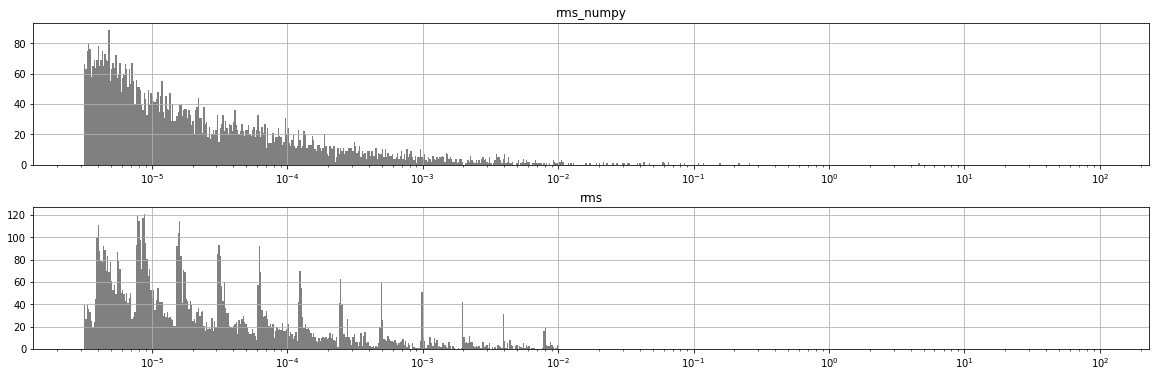

In [28]:
TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features6.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels6.csv'

df       = pd.read_csv(TRAIN_FILE  , nrows=MAX_TRACKS)
labelsdf = pd.read_csv(LABELS_FILE , nrows=MAX_TRACKS)

N = MAX_TRACKS
Nbad = 0
last_bad = -1
for irow in range(0, N):
    isValid = TestInverse( irow )
    if not isValid:
        #print('Bad inverse matrix for row: %d' % irow)
        Nbad += 1
        last_bad = irow

print('Found %d bad rows out of %d (%3.2f%%)' % (Nbad, N, 100.0*Nbad/N))
print('Details of the last bad row (%d):' % last_bad)

# Add the 'rms_numpy' column, intialized with zeros
Nrows = labelsdf.shape[0]

# Calculate RMS for all rows
rms_all = np.zeros((Nrows))
for irow in range(0,Nrows):
    rms_all[irow] = GetRMS( irow )

labelsdf['rms_numpy'] = rms_all

fig, ax = plt.subplots(2,1, figsize=(20,6))
ax[0].set_xscale("log")
ax[1].set_xscale("log")
bins = 10.0**(np.arange(-550,200)/100.0)
labelsdf.hist(ax=ax[0], column=['rms_numpy'], bins=bins, color='grey')
labelsdf.hist(ax=ax[1], column=['rms'], bins=bins, color='grey')

Above are plotted the numpy calculated rms (top) and ROOT calculated rms (bottom). (Note that ROOT has a cut at $10^{-2}$ so ignore above that). The ranges now match much better even if we could not fully reproduce the structure of the ROOT-generated distribution. I think it is OK to say now that this discrepancy looks to be due to rounding errors related to converting to/from string format. I think it is also probably OK to leave the cut in the plugin at $10^{-2}$.

## Lesson: use max precision

I think the lesson here is that if we're using csv files with pandas etc., we need to set the precision very high when we write out the numbers. The matrix multiplications can involve multiplying and adding numbers with very different orders. It may be the correct solution is just to use a binary file format instead of csv and keep the full precision that way. This will force the use of data generators in keras which could lose a lot of the performance optimizations pandas provides for large datasets. For now, we press on...